#### loading library

In [1]:
import cv2
import yaml
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

#### Conversion code

In [2]:
def model_conversion(myModel, dummy_inputs, onnx_model_pth, onnx_quant_pth):

    # onnx conversion
    torch.onnx.export(
        model = myModel,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_pth,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names    =   ["output"],
        dynamic_axes    =   {
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

    # model quantization
    quantize_dynamic(
        model_input     =   onnx_model_pth,
        model_output    =   onnx_quant_pth,
        per_channel     =   False,
        reduce_range    =   False,
        weight_type     =   QuantType.QUInt8,
    )

### model loading

In [3]:
from model import Generator
import torch

def load_model_for_inference():
    # define model
    net = Generator().cuda()
    net.load_state_dict(torch.load('./weights/paprika.pt'))
    # loading pretrained weight
    net.eval()
    print('모델 로딩 완')
    
    return net

# 1. model loading
model = load_model_for_inference()

모델 로딩 완


In [4]:
# onnx 모델 저장 경로
os.makedirs('./onnx_models/', exist_ok=True)
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 512, 512]), dtype = torch.float32).to(device)
}
# model 변환
projectName = 'AnimeGANv2'
onnx_model_path = f'./onnx_models/{projectName}.onnx'
onnx_model_quantized_path = f'./onnx_models/{projectName}_quant.onnx'

# 2. model conversion(onnx & onnx quant)
model_conversion(model, dummy_inputs, onnx_model_path, onnx_model_quantized_path)

/opt/conda/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at

---

## ONNX-Runtime Test

In [5]:
from PIL import Image
import torchvision.transforms as transforms
import cv2
from torchvision.transforms.functional import to_tensor, to_pil_image

def load_image(image_path, x32=False):
    img = Image.open(image_path).convert("RGB")

    if x32:
        def to_32s(x):
            return 256 if x < 256 else x - x % 32
        w, h = img.size
        img = img.resize((to_32s(w), to_32s(h)))

    return img

image = load_image('./rose.jpg')
image = image.resize((512, 512))
image = to_tensor(image).unsqueeze(0) # * 2 - 1
image_embedding = image.detach().cpu().numpy()
image_embedding.shape

(1, 3, 512, 512)

In [6]:
# loading
ort_session = onnxruntime.InferenceSession(onnx_model_quantized_path, providers=['AzureExecutionProvider'])
# test running
ort_inputs  = {'input': image_embedding}
#print(ort_inputs  = {'input' : image_embedding})
ort_outputs = ort_session.run(None, ort_inputs)
ort_outputs[0].shape

(512, 512, 3)

True

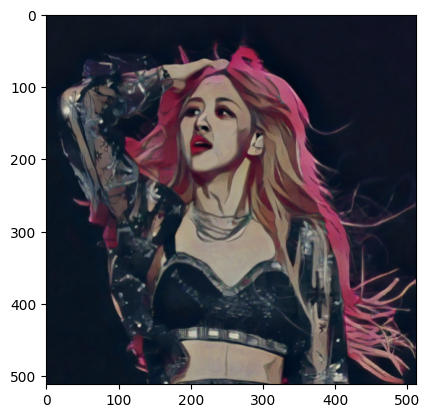

In [15]:
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

out = ort_outputs[0]
plt.imshow(out)
cv2.imwrite('./resultA.png',out)